# SVD Image Compression
## November 16th, 2021
### Overview: Using the compact SVD of a matrix representing an image to compress an image

In [1]:
import numpy as np
from numpy import linalg as la
from scipy import linalg as sla
from matplotlib import pyplot as plt
import cmath
from imageio import imread

In [2]:
# Problem 1
def compact_svd(A, tol=1e-6):
    """Compute the truncated SVD of A.

    Parameters:
        A ((m,n) ndarray): The matrix (of rank r) to factor.
        tol (float): The tolerance for excluding singular values.

    Returns:
        ((m,r) ndarray): The orthonormal matrix U in the SVD.
        ((r,) ndarray): The singular values of A as a 1-D array.
        ((r,n) ndarray): The orthonormal matrix V^H in the SVD.
    """
    #AH is A Hermitian
    AH = A.conj().T
    
    #getting the eigenvalues and vectors
    eigvals, eigvecs = la.eig(AH@A)
    
    #getting the singular values
    unsorted_singvals = np.array([np.real(cmath.sqrt(val)) for val in eigvals])
    
    #getting the indices in the order of greatest to least singular value
    indices = np.argsort(-unsorted_singvals)
    
    #starting the sorted_singvals list and sorted_vecs matrix with greatest singular value
    sorted_singvals = unsorted_singvals[indices]
    sorted_vecs = eigvecs[:,indices]
    
    #counting non-zero singvals
    r = 0
    for val in sorted_singvals:
        if val > tol: r += 1
            
    #getting the compact forms of U,sigma, and VH
    sings = sorted_singvals[:r]
    V1 = sorted_vecs[:,:r]
    U1 = A@V1/sings
    
    return U1, sings, V1.conj().T

In [61]:
# Problem 2
def visualize_svd(A):
    """Plot the effect of the SVD of A as a sequence of linear transformations
    on the unit circle and the two standard basis vectors.
    """
    #constructing 2x200 matrix of points on the unit circle
    S = np.linspace(0,2*np.pi,200)
    S = np.vstack((S,S))
    S[0] = np.cos(S[0])
    S[1] = np.sin(S[1])
    
    #creating E matrix (standard basis vectors with zero column in between)
    E = np.array([[1,0,0],[0,0,1]])
    
    #svd
    U,sig,VH = sla.svd(A)
    
    #getting matrices for plotting transformations
    VHS = VH@S
    VHE = VH@E
    sigVHS = np.diag(sig)@VHS
    sigVHE = np.diag(sig)@VHE
    UsigVHS = U@sigVHS
    UsigVHE = U@sigVHE
    
    #plotting
    fig, axs = plt.subplots(2,2)
    fig.set_size_inches(12,12)
    
    axs[0,0].plot(S[0],S[1],'b')
    axs[0,0].plot(E[0],E[1],color ='orange')
    axs[0,0].axis('equal')
    axs[0,0].set_title('S and E')
    
    axs[0,1].plot(VHS[0],VHS[1],'b')
    axs[0,1].plot(VHE[0],VHE[1],color ='orange')
    axs[0,1].axis('equal')
    axs[0,1].set_title('VHS and VHE')
    
    axs[1,0].plot(sigVHS[0],sigVHS[1],'b')
    axs[1,0].plot(sigVHE[0],sigVHE[1],color ='orange')
    axs[1,0].axis('equal')
    axs[1,0].set_title('sigVHS and sigVHE')
    
    axs[1,1].plot(UsigVHS[0],UsigVHS[1],'b')
    axs[1,1].plot(UsigVHE[0],UsigVHE[1],color ='orange')
    axs[1,1].axis('equal')
    axs[1,0].set_title('UsigVHS and UsigVHE')

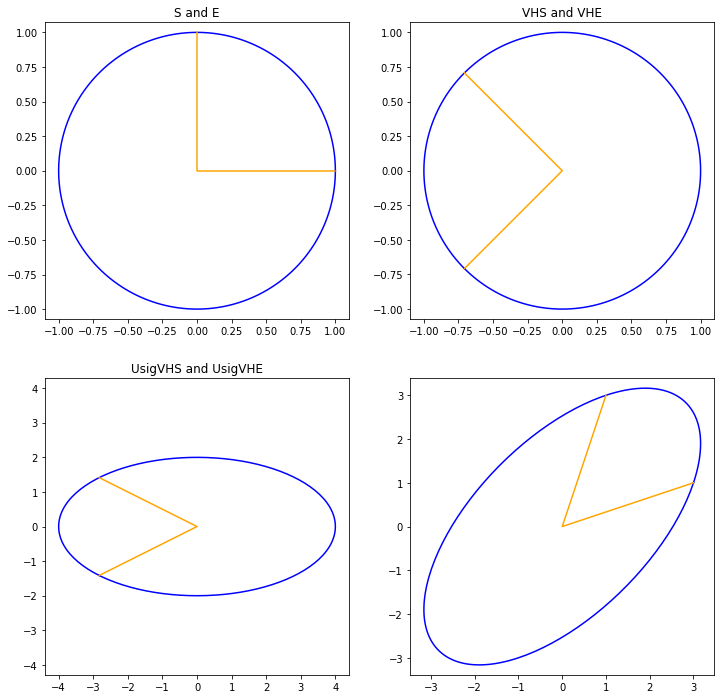

In [62]:
A = np.array([[3,1],[1,3]])
visualize_svd(A)

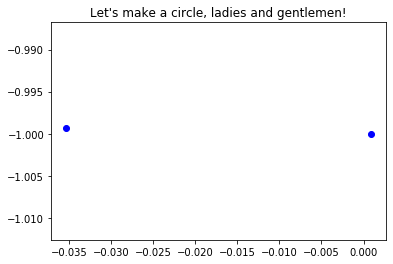

In [50]:
S = np.random.uniform(low=0,high=2*np.pi,size=(1,200))
S = np.vstack((S,S))
S[0] = np.cos(S[0])
S[1] = np.sin(S[1])
plt.axis('equal')
plt.title("Let's make a circle, ladies and gentlemen!")

ind = np.argsort(S[1])
S[0] = S[0][ind]
S[1] = S[1][ind]

plt.plot(S[0][:2],S[1][:2],'bo')

In [55]:
def plot_ellipse(a, b, c, d, e):
    """Plot an ellipse of the form ax^2 + bx + cxy + dy + ey^2 = 1."""
    theta = np.linspace(0, 2*np.pi, 200)
    cos_t, sin_t = np.cos(theta), np.sin(theta)
    A = a*(cos_t**2) + c*cos_t*sin_t + e*(sin_t**2)
    B = b*cos_t + d*sin_t
    r = (-B + np.sqrt(B**2 + 4*A)) / (2*A)

    plt.plot(r*cos_t, r*sin_t,color='r')
    plt.gca().set_aspect("equal", "datalim")

# Problem 4
def ellipse_fit():
    """Calculate the parameters for the ellipse that best fits the data in
    ellipse.npy. Plot the original data points and the ellipse together, using
    plot_ellipse() to plot the ellipse.
    """
    #getting the x and y values from the data
    x = S.T[:,0].copy()
    y = S.T[:,1].copy()
    
    #forming A by stacking the column vectors in order of x^2 + x + xy + y + y^2
    A = np.column_stack((x**2, x, x*y, y, y**2))
    
    #making b
    b = np.ones(200)
    
    #solving for the least squares solution
    coeffs = sla.lstsq(A,b)[0]
    
    #plotting
    plt.title("Ellipse points and best-fitting ellipse")
    #plt.scatter(x,y,color='k',marker='.')
    plot_ellipse(coeffs[0], coeffs[1] , coeffs[2] , coeffs[3] , coeffs[4])

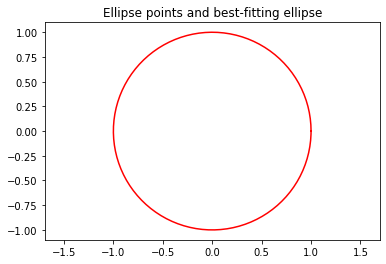

In [56]:
ellipse_fit()

In [40]:
v = np.array([2,1,4,3])
ind = np.argsort(v)
v = v[ind]
print(v)

[1 2 3 4]


In [68]:
# Problem 3
def svd_approx(A, s):
    """Return the best rank s approximation to A with respect to the 2-norm
    and the Frobenius norm, along with the number of bytes needed to store
    the approximation via the truncated SVD.

    Parameters:
        A ((m,n), ndarray)
        s (int): The rank of the desired approximation.

    Returns:
        ((m,n), ndarray) The best rank s approximation of A.
        (int) The number of entries needed to store the truncated SVD.
    """
    #checking s is greater than number of nonzero singular values
    if s > la.matrix_rank(A):
        raise ValueError("s cannot be greater the rank of A")
    
    #calculating compact SVD
    U1,S1,V1 = sla.svd(A,full_matrices=False)
    
    #truncating
    Us = U1[:,:s]
    Ss = S1[:s]
    Vs = V1[:s,:]
    
    #calculating truncated A
    As = Us@np.diag(Ss)@Vs
    
    #getting number of entries needed to store the truncated SVD
    size = Us.size + Ss.size + Vs.size
    
    return As, size

In [5]:
# Problem 4
def lowest_rank_approx(A, err):
    """Return the lowest rank approximation of A with error less than 'err'
    with respect to the matrix 2-norm, along with the number of bytes needed
    to store the approximation via the truncated SVD.

    Parameters:
        A ((m, n) ndarray)
        err (float): Desired maximum error.

    Returns:
        A_s ((m,n) ndarray) The lowest rank approximation of A satisfying
            ||A - A_s||_2 < err.
        (int) The number of entries needed to store the truncated SVD.
    """
    #computing compact svd
    U1,S1,V1 = compact_svd(A)
    
    #array of all singular values less than error; -1 in all other locations 
    where = np.where(S1<err,S1,-1)
    
    #checking whether all the values were greater than error
    if all([i == -1 for i in where]):
        raise ValueError("error is less than or equal to the smallest singular value of A")
    
    #getting lowest rank within error
    s = np.argmax(where)
    
    return svd_approx(A,s)

In [73]:
# Problem 5
def compress_image(filename, s):
    """Plot the original image found at 'filename' and the rank s approximation
    of the image found at 'filename.' State in the figure title the difference
    in the number of entries used to store the original image and the
    approximation.

    Parameters:
        filename (str): Image file path.
        s (int): Rank of new image.
    """
    image = imread(filename)/255
    color = len(image.shape) == 3
    
    if color == True:
        #separating the Red, Green, and Blue layers
        R = image[:,:,0]
        G = image[:,:,1]
        B = image[:,:,2]
        
        #getting the s-rank approximation
        Rs, rs = svd_approx(R,s)
        Gs, gs = svd_approx(G,s)
        Bs, bs = svd_approx(B,s)
        
        #reassembling the now-approximated color image
        im_approx = np.dstack((Rs,Gs,Bs))
        
        #clipping the individuals arrays
        m,n,l = im_approx.shape
        im_approx = np.clip(im_approx,0,1)
        #for i in range(m):
        #    for j in range(n):
        #        im_approx[i,j] = np.clip(im_approx[i,j],0,1)
                                    
        #plotting
        fig, axs = plt.subplots(1,2)
        fig.set_size_inches(12,12)
        plt.suptitle("Number of original entries: " + str(image.size) + '; s-ranked approximation: ' 
                     + str(rs+gs+bs) + '; Number of entries saved: ' + str(image.size - (rs+gs+bs)), size = 20)
        axs[0].imshow(image)
        axs[0].set_title("Original Image")
        axs[1].imshow(im_approx)
        axs[1].set_title("Approximated Image")
    else:
        #getting the s-rank approximation
        im_approx, size = svd_approx(image,s)
        
        #plotting
        fig, axs = plt.subplots(1,2)
        fig.set_size_inches(12,12)
        plt.suptitle("Number of original entries: " + str(image.size) + '; s-ranked approximation: ' 
                     + str(size) + '; Number of entries saved: ' + str(image.size - size), size = 20)
        axs[0].imshow(image,cmap='gray')
        axs[0].set_title("Original Image")
        axs[1].imshow(im_approx,cmap='gray')
        axs[1].set_title("Approximated Image")

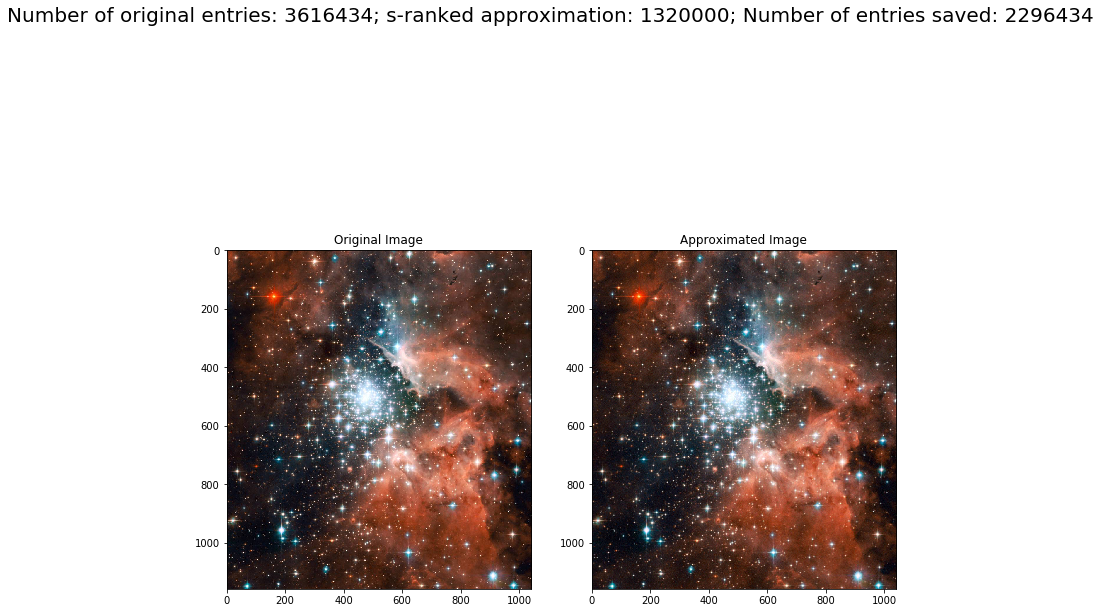

In [74]:
compress_image('hubble.jpg',200)